<a href="https://colab.research.google.com/github/ngotancuong/mse.python/blob/main/Baitap01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HƯỚNG DẪN PHẬN TÍCH KHÁM PHÁ DỮ LIỆU (EDA), PHÂN TÍCH DỮ LIỆU CHUỖI THỜI GIAN VÀ CÁC DỰ BÁO DỰA VÀO MÔ HÌNH SARIMAX

Cuộc thi này do Walmart tài trợ có tên là Dự báo M5. Sử dụng dữ liệu bao gồm khoảng 30.000 mặt hàng khác nhau trong gần 1900 ngày. Mục tiêu là dự báo doanh số bán hàng trong 28 ngày tới. Phân bố ở ba Tiểu bang Hoa Kỳ (California, Texas và Wisconsin).

### Import các thư viện cần thiết

In [ ]:
# Đây là môi trường Python 3 với các gói thư viện hữu ích được cài đặt sẵn
# Được giải thích kỹ hơn tại kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np # Thư viện xử lý đại số tuyến tính, xử lý các Tensor
import pandas as pd # Thư viện hỗ trợ xử lý dữ liệu dạng Series, DataFrame,..., xử lý file ví dụ CSV file I/O (sử dụng pd.read_csv)
import matplotlib.pyplot as plt # Thư viện hỗ trợ trực quan hoá dữ liệu

# Thư viện xử lý chuỗi thời gian
import time
import math
import datetime

# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

# Thư viện hỗ trợ tính toán và học máy
from math import log, floor
from sklearn.neighbors import KDTree

# Thư viện hỗ trợ trực quan hoá dữ liệu
import seaborn as sns
sns.set_style('whitegrid')

# Thư viện thỗ trợ rực quan và phân tích dữ liệu
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Thư viện tạo GUI cho Python
import pywt
from statsmodels.robust import mad

# Thư viện bổ sung cho Numpy
import scipy
import statsmodels
from scipy import signal

# Thư viện cung cấp nhiều công cụ để phân tích dữ liệu thống kê
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

# Thư viện cung cấp các chức năng khác nhau hoạt động trên các vòng lặp phức tạp
import itertools
from itertools import cycle
plt.style.use('seaborn')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Tắt cảnh báo về tương thích phiên bản 
# Example FutureWarning: `distplot` is a deprecated function and will be removed in a future version
import warnings
warnings.filterwarnings("ignore")

# Đọc các Datasets vào vào các Data Frame
sell_prices_df = pd.read_csv('https://media.githubusercontent.com/media/ngotancuong/mse.python/master/data/input/sell_prices.csv')
train_sales_df = pd.read_csv('https://media.githubusercontent.com/media/ngotancuong/mse.python/master/data/input/sales_train_validation.csv')
calendar_df = pd.read_csv('https://media.githubusercontent.com/media/ngotancuong/mse.python/master/data/input/calendar.csv')
submission_file = pd.read_csv('https://media.githubusercontent.com/media/ngotancuong/mse.python/master/data/input/sample_submission.csv')

print("Import dataset thành công. Dữ liệu đã được nạp vào 4 Data Frame")

Import dataset thành công. Dữ liệu đã được nạp vào 4 Data Frame


#### Mô tả các Dataset:

Các file dataset đã import vào có những nội dung như sau

* `calendar_df.csv` - Chứa thông tin về ngày sản phẩm được bán và cũng chứa thông tin về các ngày lễ và các dịp đặc biệt.
* `train_sales_df.csv` - Chứa dữ liệu lịch sử bán hàng hàng ngày tại từng cửa hàng trong khoảng 1900 ngày [d_1 - d_1913] 
* `submission_file.csv` - Những file submit đúng định dạng, bao gồm product ids, column ids cho việc dự báo doanh thu bán hàng 28 ngày kế tiếp. 
* `sell_prices_df.csv` - Bao gồm thông tin về giá sản phẩm được bán tại từng cửa hàng mỗi ngày.
* `sales_train_evaluation.csv` - Bao gồm doanh số [d_1 - d_1941] (dùng cho việc khen thưởng, tuyên dương nhân viên)

### Kiểm tra vài thông tin về Data Frame



In [ ]:
sell_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [ ]:
train_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [ ]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


Chúng ta có thể thấy 'sell_prices_df' chứa đến 6.841.121 giao dịch ở cấp độ cửa hàng. 'train_sales_d' chứa 30.490 sản phẩm khác nhau. Và 'calendar_df' có thể dùng để phân tích theo chuỗi thời gian các sản phẩm đã bán.

### EDA (Exploratory Data Analysis) - Phân tích khám phá dữ liệu

#### Các câu hỏi về phân phối sản phẩm và hành vi theo thời gian

In [ ]:
# Lấy ra 3 dòng đầu tiên của Data Frame để xem nó chứa dữ liệu gì để khai thác
train_sales_df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,total_sales_all_days,avg_sales_all_days,median_sales_all_days
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,3,0,1,1,600,0.313643,0.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,0,493,0.257710,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,0,1,1,1,288,0.150549,0.0


In [ ]:
# Trả về danh sách các tiêu đề cột có chứa tiền tố 'd_' (tức là cột ngày)
d_cols = [c for c in train_sales_df.columns if 'd_' in c]
# Tổng số ngày bán hàng được tính là sum của các cột (axis=1 là đếm ngang)
train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
# train_sales_df[d_cols] là dataframe chứa các cột và dòng dữ liệu ngày bán hàng
# Hàm mean là tính giá trị trung bình
train_sales_df['avg_sales_all_days'] = train_sales_df[d_cols].mean(axis = 1)
# Hàm median là tính giá trị trung vị
train_sales_df['median_sales_all_days'] = train_sales_df[d_cols].median(axis = 1)
#train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

#### Biểu đồ doanh số sản phẩm theo Loại sản phẩm

In [ ]:
# Data Frame gom nhóm sản phẩm theo category và đếm số lượng sản phẩm có phát sinh giao dịch trong category tương ứng
df = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
# Hàm vẽ biểu đồ hình bánh
fig = px.pie(df, values='total_entries', names='cat_id', 
            color_discrete_sequence=px.colors.sequential.RdBu,
            width = 750, height=450, title = 'Số lượng sản phẩm theo Category có phát sinh giao dịch')
fig.show()

Theo biểu đồ ta thấy Thực phẩm là mặt hàng có nhiều mã sản phẩm bán ra nhất (chiếm 47.1%), tiếp theo là đồ gia dụng và sau đó là đồ theo sở thích.

In [ ]:
#Dataframe chứa tổng doanh số theo bang
df = train_sales_df.groupby(['state_id'])['total_sales_all_days'].sum().reset_index()

fig = px.pie(df, values='total_sales_all_days', names='state_id', 
            color_discrete_sequence=px.colors.sequential.Aggrnyl,
            width = 750, height=450, title = 'Doanh số sản phẩm theo bang')
fig.show()

Tổng doanh số hàng bán ở Bang CA là cao nhất (43.6%), kế tiếp là Texas và Wisconsin

In [ ]:
# Đếm số lượng sản phẩm có phát sinh giao dịch theo từng category và lưu vào data frame
df1 = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
# Tính tổng doanh số theo category và state, lưu vào data frame
df2 = train_sales_df.groupby(['cat_id', 'state_id'])['total_sales_all_days'].sum().reset_index()

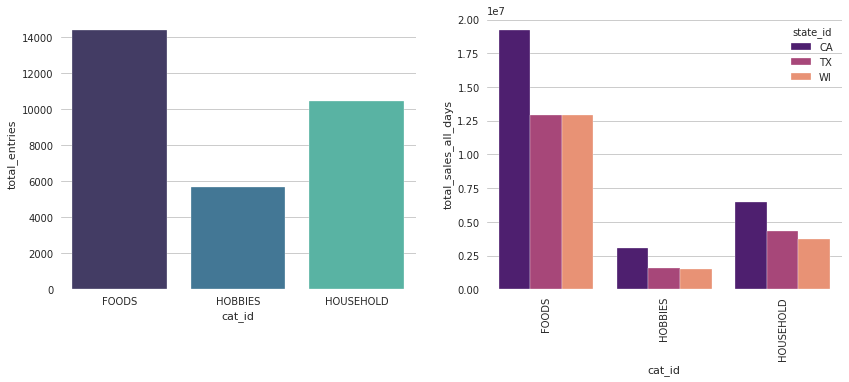

In [ ]:
# Dùng thư viện seaborn để vẽ biểu đồ hình cột 
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
# Gọi hàm vẽ biểu đồ và truyền tham số
sns.barplot(x = 'cat_id', y='total_entries', data=df1, 
            palette='mako', ax=ax1)
sns.barplot(x = 'cat_id', y='total_sales_all_days', hue='state_id', data=df2, 
            palette='magma', ax=ax2)
# Xoay text trên trục x 90 độ
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Đếm sản phẩm có phát sinh giao dịch gom nhóm theo category và state, đưa vào data frame
df = train_sales_df.groupby(['state_id', 'cat_id'])['id'].count().reset_index(name='num_sales_by_category')
# Vẽ biểu đồ hình cột
fig = px.bar(df, x="state_id", y="num_sales_by_category", 
             color="cat_id", title="Sản phẩm có phát sinh giao dịch gom nhóm theo Category và State")
fig.show()

#### Biểu đồ phân phối các mặt hàng theo Loại sản phẩm và Cửa hàng

In [ ]:
# Gom nhóm Deparment, Store, State, Category. Sau đó tính tổng doanh số toàn thời gian.
# Bắt đâu tính tổng từ cột có index=6 ( tức là cột d_1 tới cuối)
df = train_sales_df.groupby(['dept_id', 'store_id', 'state_id', 'cat_id'])[train_sales_df.columns[6:]].sum().reset_index()
# Sắp xếp kết quả tính toán theo giá trị từ cao xuống thấp.
df = df.sort_values('total_sales_all_days', ascending=False)
# print(df['d_50'])

In [ ]:
x_dept = df['dept_id']
x_store = df['store_id']
# Định nghĩa hàm tính số lượng sản phẩm được bán trong ngày
def items_sold_per_days(x_spec,title_text, title):
    
    '''
    returns plotly plots with drop down menus for specified parameter made in dataframe earlier
    
    inputs: x_spec (categorical feature on the x_axis), title_text(title on dropdown), 
            title (title of the plot)
            
    returns: plotly plots of categorical feature (x_axis) with dropdowns on specific 
    number of days        
    '''
    
    cols = ['d_1', 'd_50', 'd_300', 'd_500', 'd_700', 'd_900', 'd_1100', 'd_1500', 'd_1700',
        'total_sales_all_days', 'median_sales_all_days']
    # Khởi tạo và nạp giá trị dropdown list
    buttons1 = [dict(method = "restyle",
                 args = [{'x': [x_spec, 'undefined'],
                          'y': [df[cols[k]], 'undefined'],
                          'visible':[True, False]}], 
                 label = cols[k])   for k in range(0, len(cols))]
    # Khởi tạo instance vẽ lưới cơ sở
    fig = go.Figure()
    # Khởi tạo giá trị trục x, y,...
    fig.add_trace(go.Bar(x=x_spec, y = df['d_1'], name='Dept.Sales on day2',
                     marker_color='Crimson'))
    # Cập nhật layout của biểu đồ như tiêu đề, kích thước, giá trị dropdown list đã chọn
    fig.update_layout(title_text= title_text,
                  title_x= 0.4, width=750, height=450, 
                  margin=dict(t=100, b=20, l=0, r=0),
                  autosize = False,
                  updatemenus=[dict(active=0,
                                    buttons=buttons1,
                                    x=0.08,
                                    y=1.13,
                                    xanchor='left',
                                    yanchor='top')
                              ]); 
    # Chèn chú thích cho dropdown list
    fig.add_annotation( x=0.00,  y=1.13, showarrow=False, xref='paper', yref='paper', xanchor='left',
                   text="With<br>"+str(title));
    fig.show()
# Gọi hàm và truyền tham số để vẽ biểu đồ
items_sold_per_days(df['store_id'], 'Doanh số theo Store', 'Stores')
items_sold_per_days(df['state_id'], "Doanh số theo State", 'States')

#### Mặt hàng cụ thể Bán chạy nhất?

In [ ]:
# Doanh số sản phẩm bán chạy nhất, xếp theo giá trị giảm dần
train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

id
FOODS_3_090_CA_3_validation        250502
FOODS_3_586_TX_2_validation        192835
FOODS_3_586_TX_3_validation        150122
FOODS_3_586_CA_3_validation        134386
FOODS_3_090_CA_1_validation        127203
                                    ...  
FOODS_2_071_TX_3_validation            16
FOODS_2_057_WI_2_validation            16
HOBBIES_1_170_WI_3_validation          13
FOODS_3_778_CA_2_validation            12
HOUSEHOLD_1_020_CA_3_validation        10
Name: total_sales_all_days, Length: 30490, dtype: int64

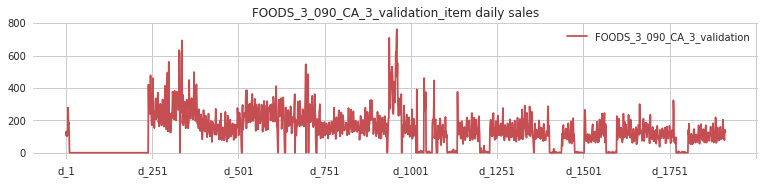

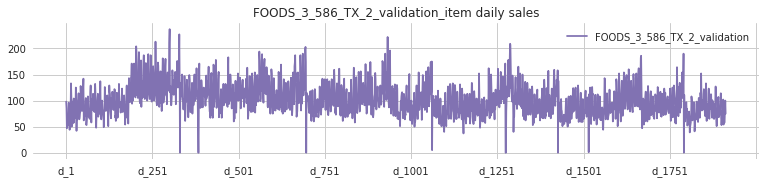

In [ ]:
sns.set_style('whitegrid')
# Định nghĩa hàm vẽ biểu đồ doanh số hàng ngày
def plot_dailysales(spec_id):
    """
    plots the behavior of dailysales of specific ids i.e. spec_id
    
    input: spec_id
    returns : number of sales plotted across number of days 
    """
    train_sales_df.loc[train_sales_df['id'] == spec_id ].set_index('id')[d_cols].T\
                .plot(figsize = (13,2.5),
                      title =  str(spec_id)+"_item daily sales", 
                      color = next(color_cycle) )
    # Chèn chú thích vào biểu đồ
    plt.legend()
    plt.show()
# Gọi hàm vẽ biểu đồ, truyền tham số là id của 2 sản phẩm có doanh số cao nhất
plot_dailysales('FOODS_3_090_CA_3_validation') 
plot_dailysales('FOODS_3_586_TX_2_validation')

#### Sản phẩm bán chạy nhất trong mỗi Loại sản phẩm

In [ ]:
# Tính tổng doanh số theo gom nhóm id, category, store đưa vào data frame, xấp thứ tự giảm dần
df_agg = pd.DataFrame(train_sales_df.groupby(['id', 'cat_id', 'store_id'])['total_sales_all_days'].sum().sort_values(ascending=False))
df_agg = df_agg.reset_index()
df_agg.head(3)

,id,cat_id,store_id,total_sales_all_days
0,FOODS_3_090_CA_3_validation,FOODS,CA_3,250502
1,FOODS_3_586_TX_2_validation,FOODS,TX_2,192835
2,FOODS_3_586_TX_3_validation,FOODS,TX_3,150122


In [ ]:
# In ra 3 sản phẩm bán chạy nhất theo từng Gian hàng
print("The 3 item_ids outselling most in FOODS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'FOODS']['id'][:3])))
print("The 3 item_ids outselling most in HOUSEHOLDS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOUSEHOLD']['id'][:3])))
print("The 3 item_ids outselling most in HOBBIES category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOBBIES']['id'][:3])))

The 3 item_ids outselling most in FOODS category are: ['FOODS_3_090_CA_3_validation', 'FOODS_3_586_TX_2_validation', 'FOODS_3_586_TX_3_validation']
The 3 item_ids outselling most in HOUSEHOLDS category are: ['HOUSEHOLD_1_118_CA_3_validation', 'HOUSEHOLD_1_459_CA_3_validation', 'HOUSEHOLD_1_334_CA_3_validation']
The 3 item_ids outselling most in HOBBIES category are: ['HOBBIES_1_234_CA_3_validation', 'HOBBIES_1_348_CA_1_validation', 'HOBBIES_1_371_CA_1_validation']


In [ ]:
#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))
# Hàm vẽ biểu đồ dựa theo tham số là mã sản phẩm, ngày bắt đầu, ngày kết thúc, bước nhảy
def plot_sample_sales(spec_id, sm_start, sm_end, samples_pick=50):
    """
    plots sample sales data with selection point and ending point specified, along with
    samples_pick point that specifies the samples picked after specified intervals
    
    input: spec_id (item_id or id), sm_start (sample_start), sm_end(sample_end),
    samples_pick (samples picked after how many intervals)
    
    returns: outputs a graph of sample points plotted against daily sales data d_1 to d_1913
    """
    fig, ax1 = plt.subplots(figsize=(13, 2.5))
    
    x1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .columns)[sm_start:sm_end]
    y1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .values.flatten())[sm_start:sm_end]
    
    #this conversion for regplot only
    x1 = [x.replace("d_", "") for x in x1]
    x1 = [int(x) for x in x1]
    
    #sns.lineplot(x=x1, y=y1, ax=ax1)
    sns.regplot(x=x1, y=y1, order=10, ax=ax1)
    ax1.set_ylabel("Number of Sales")
    ax1.set_xlabel("Days")

    ax1.set_xticks(x1[::samples_pick])
    ax1.set_xticklabels(x1[::samples_pick], rotation=0)

    fig.tight_layout()
    plt.show()

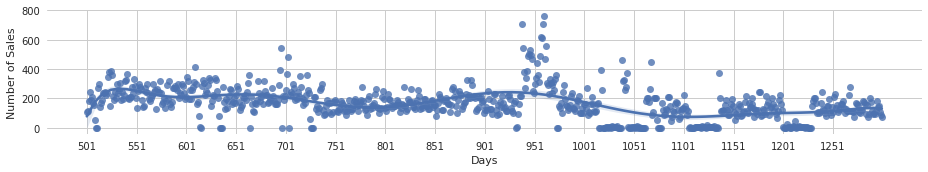

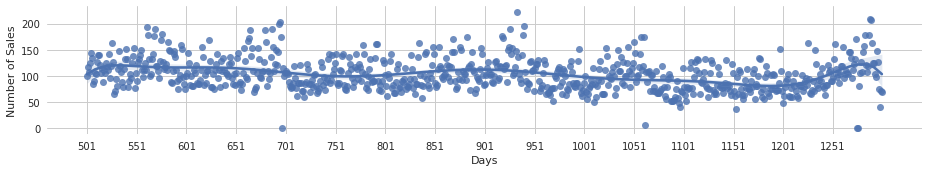

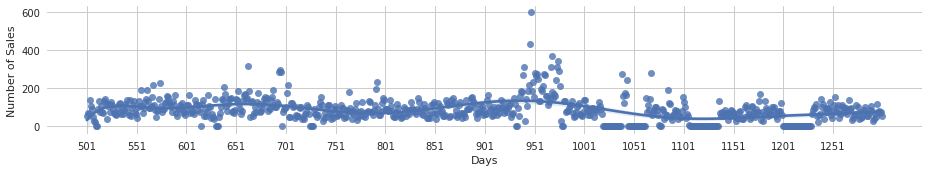

In [ ]:
# Gọi phương thức vẽ biểu đồ với ngày bắt đầu là ngày thứ 500, kết thúc là ngày 1300, bước nhảy mặc định là 50
plot_sample_sales('FOODS_3_090_CA_3_validation', 500, 1300)
plot_sample_sales('FOODS_3_586_TX_2_validation', 500, 1300)
plot_sample_sales('FOODS_3_090_CA_1_validation', 500, 1300)

### Những câu hỏi về doanh thu bán hàng?

In [ ]:
# Show ra 3 sản phẩm đầu tiên trong bảng dữ liệu
sell_prices_df.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


In [ ]:
# Tạo một cột mới chứa Category tách ra từ cột item_id, lấy giá trị từ vị trí 0 tới dấu _ thì dừng
sell_prices_df['category'] = sell_prices_df['item_id'].str.split("_", expand=True)[0]

#### Phân bổ giá giữa các Category

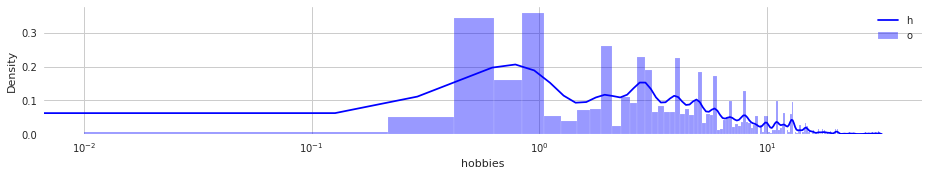

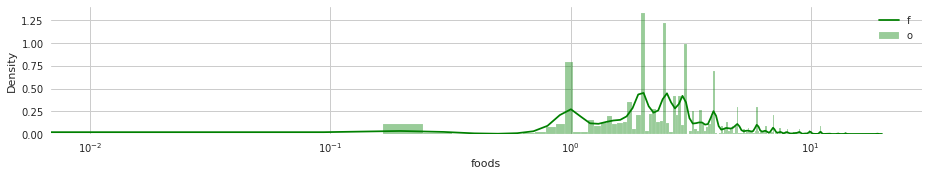

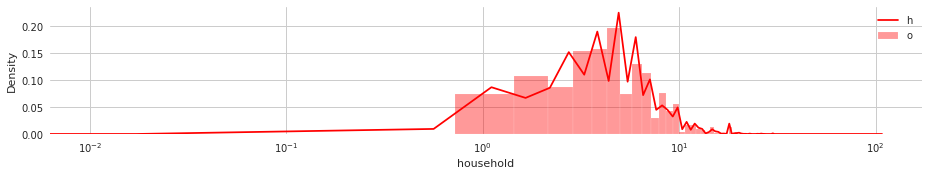

In [ ]:
sns.set_style('whitegrid')
#plt.figure(figsize=(15,5))

def kde_plotting(df, category, bin_size, color, label):
    
    '''
    plots the kde density plot of the continuous features of df specified
    
    inputs: df, category(whether, foods, household or hobbies), bin_size(bin size for histogram)
            color (color of the plot), label (label to the plot)
    returns: kde plots with logarithmic scale taken on x_axis
            
    '''
    fig, ax1 = plt.subplots(figsize=(13, 2.5) )
    # Hàm distplot thể hiện sự phân bổ dữ liệu, cụ thể ở đây là phân bổ doanh thu theo loại sản phẩm và chia theo số lượng cột = tham số bins
    sns.distplot(df[df['category'] == category]['sell_price'], 
               axlabel = label ,bins=bin_size, color = color, ax=ax1) 

    fig.tight_layout()
    ax1.set_xscale('log')
    plt.legend(label)
    plt.show()
# Gọi hàm vẽ biểu đồ, tuyền tham số   
kde_plotting(sell_prices_df, 'HOBBIES', 150, 'b', 'hobbies')   
kde_plotting(sell_prices_df, 'FOODS', 250, 'g', 'foods') 
kde_plotting(sell_prices_df, 'HOUSEHOLD', 150, 'r', 'household') 

#### Loại bỏ các yếu tố ngoại lai để theo dõi phân phối giá? => Làm sạch dữ liệu
#### **Phương pháp Tứ vị phân**

In [ ]:
def remove_outliers(df):
    
    '''
    loại bỏ các giá trị ngoại lệ sử dụng hàm quartile, đây là hàm tổng quát của hàm median. Chia mẫu thống kê thành nhiều phần có số phần tử bằng nhau.
    inputs: df(df specified with continous features along side categorical features)
    returns: df with removed outliers
    '''
    Q1=df.quantile(0.25)
    print(Q1)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    
    return df_final

df = sell_prices_df[['category', 'sell_price']]
df = remove_outliers(df)

sell_price    2.18
Name: 0.25, dtype: float64


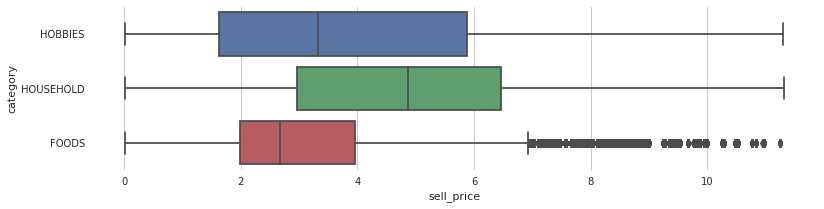

In [ ]:
# Gọi hàm vẽ biểu đồ, truyền vào tham số data frame đã được loại bỏ các giá trị ngoại lệ.
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.boxplot(y=df['category'], x=df['sell_price'])
plt.show()

#### Sư phân bổ doanh số vào các ngày trong tuần và các dịp đặc biệt?

In [ ]:
calendar_df.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,days,events_names,events_types
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,29,NaN,NaN
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,30,NaN,NaN
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,31,NaN,NaN


In [ ]:
calendar_df.groupby(['event_name_1', 'event_type_1'])['wday'].count()

event_name_1         event_type_1
Chanukah End         Religious       5
Christmas            National        5
Cinco De Mayo        Cultural        5
ColumbusDay          National        5
Easter               Cultural        5
Eid al-Fitr          Religious       5
EidAlAdha            Religious       5
Father's day         Cultural        4
Halloween            Cultural        5
IndependenceDay      National        5
LaborDay             National        5
LentStart            Religious       6
LentWeek2            Religious       6
MartinLutherKingDay  National        5
MemorialDay          National        6
Mother's day         Cultural        6
NBAFinalsEnd         Sporting        6
NBAFinalsStart       Sporting        6
NewYear              National        5
OrthodoxChristmas    Religious       5
OrthodoxEaster       Religious       5
Pesach End           Religious       6
PresidentsDay        National        6
Purim End            Religious       6
Ramadan starts       Religious

In [ ]:
calendar_df.groupby(['event_name_2', 'event_type_2'])['wday'].count()

event_name_2    event_type_2
Cinco De Mayo   Cultural        1
Easter          Cultural        1
Father's day    Cultural        2
OrthodoxEaster  Religious       1
Name: wday, dtype: int64

In [ ]:
# Nối event_1 và event_2 thành 1 data frame calendar_df với 2 trường dữ liệu là event_names và event_types
calendar_df['days'] = [d.split('-')[2] for d in calendar_df['date']]
calendar_df['events_names'] = pd.concat([calendar_df['event_name_1'], calendar_df['event_name_2']], 
                                        ignore_index=True)
calendar_df['events_types'] = pd.concat([calendar_df['event_type_1'], calendar_df['event_type_2']], 
                                        ignore_index=True)
#calendar_df.drop(['event_name_1', 'event_name_2', 'event_type_1', 'event_type_2'], axis=1, inplace=True)

#### SNAP_CA, SNAP_TX, SNAP_WI?

SNAP là viết tắt của "Chương trình Hỗ trợ Dinh dưỡng Bổ sung" là một chương trình cấp liên bang nhằm cung cấp thực phẩm thiết yếu cho các hộ gia đình có thu nhập thấp. Chương trình này hướng tới việc cung cấp các thực phẩm cần thiết và trong bộ dữ liệu hiện tại, danh mục các vật dụng gia đình và các vật dụng sở thích không nằm trong yêu cầu của chương trình này.

Chương trình này chỉ nhằm mục đích chống lại nạn đói ở Mỹ và chỉ có thể mua các mặt hàng liên quan đến thực phẩm theo chương trình này

In [ ]:
# Gom nhóm các loại event và đếm snap_CA (chương trình snap tại bang CA)
df = calendar_df.groupby(['events_types'])['snap_CA'].value_counts().reset_index(name='counts')

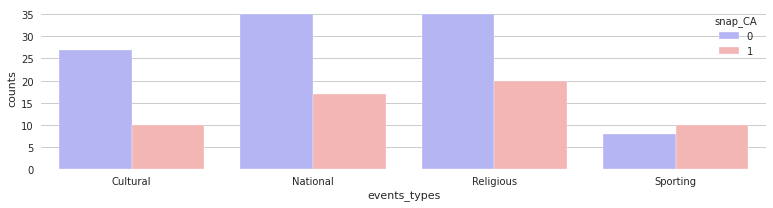

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_types', y='counts', hue='snap_CA', data=df, palette='bwr')
plt.show()

In [ ]:
df = calendar_df.groupby(['events_names'])['snap_CA'].value_counts().reset_index(name='counts')

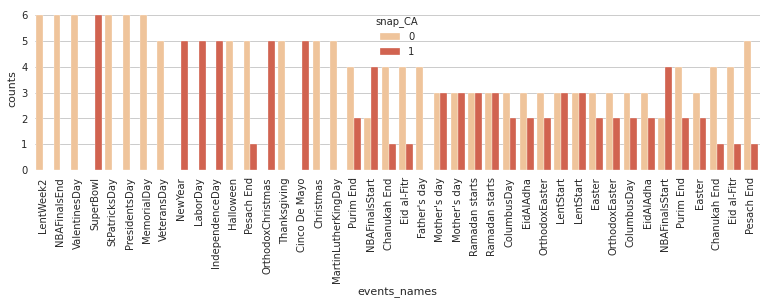

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_names', y='counts', hue='snap_CA', data=df, 
            order = df.sort_values(['counts'], ascending=False).events_names, 
            palette='OrRd')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#product id df (train_sales_df) vs revenue_df(sell_prices_df)
train_sales_prices_df = train_sales_df.merge(sell_prices_df, how='inner',  
                                            left_index=True, right_index=True, 
                                            validate="1:1")

In [ ]:
df = train_sales_prices_df.groupby(['cat_id', 'state_id', 'store_id_x'])['sell_price'].sum().reset_index(name='total_revenue')
df = df.sort_values(by='total_revenue', ascending=False)

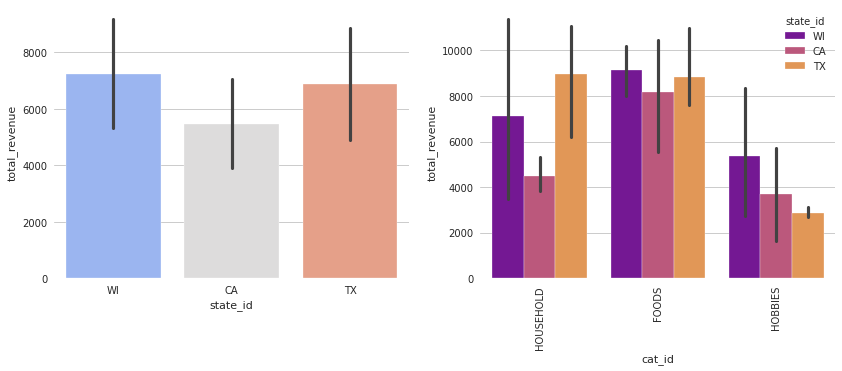

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'state_id', y='total_revenue', data=df, 
            palette='coolwarm', ax=ax1)
sns.barplot(x = 'cat_id', y='total_revenue', hue='state_id', data=df, 
            palette='plasma', ax=ax2)

plt.xticks(rotation=90)
plt.show()

### Hành vi trên TimeSeries & Analysis?

#### Phân phối Tổng doanh số so với Product_id theo thời gian?

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)

In [ ]:
train_sales_cal_df = train_sales_cal_df[['total_sales']]
train_sales_cal_df = train_sales_cal_df.reset_index()

In [ ]:
fig = px.line(train_sales_cal_df, x='date', y="total_sales", 
             template = 'plotly_white', title = 'Total Sales by Product id', 
             width=800, height=450)

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all")
            ]) 
                      ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

def time_series_decompose(df, model_specified, period):

    '''
    returns decomposed time series components (with seasonality, trend and residuals ) of time_series df
    
    inputs: df(time series df), model_specified (whether additive or multiplicative ), period(number of days)
    returns: trend values, seasonality values and residual values of time_series df
    
    '''
    df_decomposition = seasonal_decompose(
                               x=df.set_index(['date']), 
                               model= model_specified, 
                               period=period)
    
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    return est_trend, est_seasonal, est_residual

sample_time_s1 = train_sales_cal_df[400:700]
est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 
                                                              'multiplicative', 30)

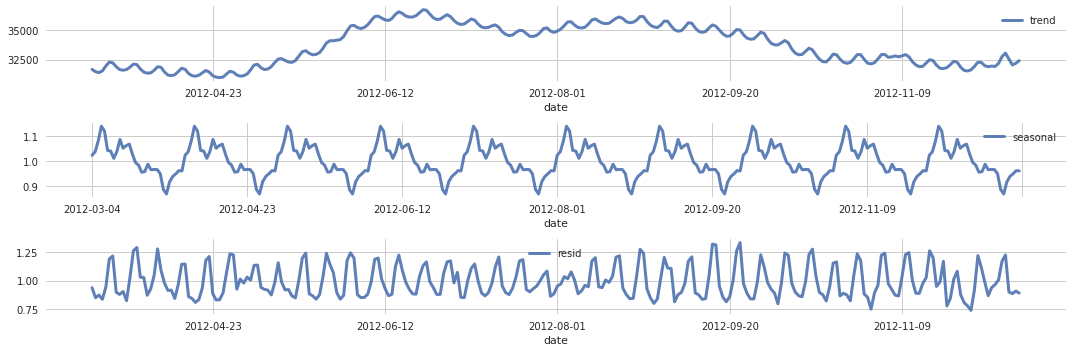

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

est_trend.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax1)
est_seasonal.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax2)
est_residual.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax3)

fig.tight_layout()
plt.show()

In [ ]:
train_sales_cal_df = train_sales_cal_df.set_index('date')

In [ ]:
def time_and_rolling_plot(df, title_text, rolling_days=30, height=2.2):

    '''
    plots the time_series of dailysales made along with rolling mean plot
    
    inputs: df, title_text(plot title), rolling_days (rolling mean to be taken across), 
            height(height of the plot to be specified)
            
    returns: time series plot and rolling mean plot of the variable specified 
    '''
    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(13, height))
    df.plot(figsize=(13, height),
                        alpha=0.8,
                        title="Time Plot for the " + str(title_text), 
                        lw=2, color=next(color_cycle), ax=ax1)
    df.rolling(rolling_days).mean().plot(figsize=(13, height),
                                          alpha=1, 
                                          legend="Rolling Mean on 30 days", 
                                          lw=2.5, color=next(color_cycle), ax=ax1)
    ax1.legend(['Total Sales Per Category', 'total_sales_rolling_mean'])
    plt.show()

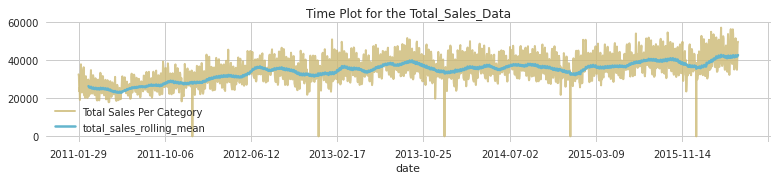

In [ ]:
time_and_rolling_plot(train_sales_cal_df, 'Total_Sales_Data')

In [ ]:
#finding the product_ids of 25 most sold units
train_sales_most_sold_25 = train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)[:25]
train_sales_most_sold_25 = train_sales_most_sold_25.reset_index(name='total_sales')
train_sales_most_sold_25.iloc[0:5]

,id,total_sales
0,FOODS_3_090_CA_3_validation,250502
1,FOODS_3_586_TX_2_validation,192835
2,FOODS_3_586_TX_3_validation,150122
3,FOODS_3_586_CA_3_validation,134386
4,FOODS_3_090_CA_1_validation,127203


In [ ]:
train_sales_most_sold_25['state'] = train_sales_most_sold_25['id'].str.split("_", expand=True)[3]
train_sales_most_sold_25.groupby(['state'])['total_sales'].sum().sort_values(ascending=False)

state
TX    1233196
CA    1005717
WI     470367
Name: total_sales, dtype: int64

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

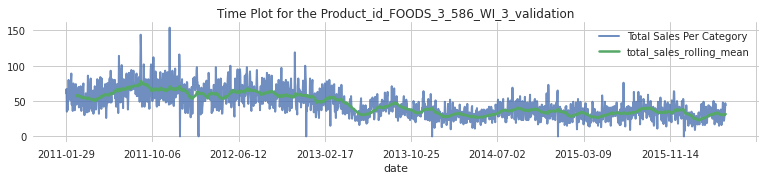

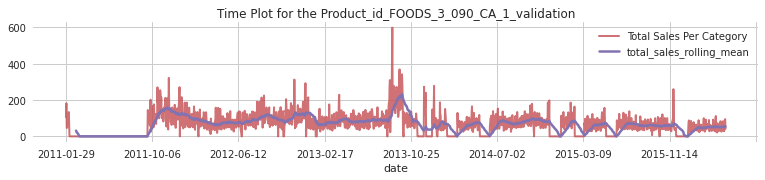

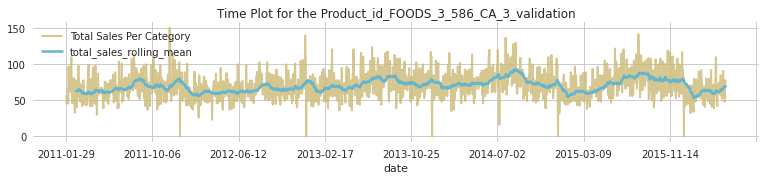

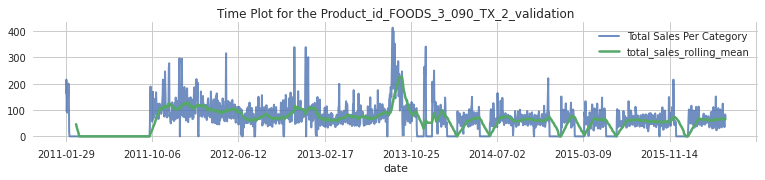

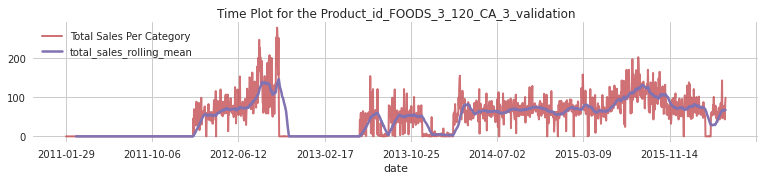

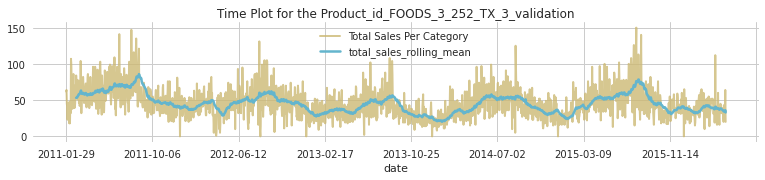

In [ ]:
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_WI_3_validation']], "Product_id_FOODS_3_586_WI_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_CA_1_validation']], "Product_id_FOODS_3_090_CA_1_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_CA_3_validation']], "Product_id_FOODS_3_586_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_TX_2_validation']], "Product_id_FOODS_3_090_TX_2_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_120_CA_3_validation']], "Product_id_FOODS_3_120_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_252_TX_3_validation']], "Product_id_FOODS_3_252_TX_3_validation")

#### Phân phối Tổng Doanh số đối với mỗi Category?

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum().\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df.head(2)

,FOODS,HOBBIES,HOUSEHOLD
date,,,
2011-01-29,23178,3764,5689
2011-01-30,22758,3357,5634


In [ ]:
def plotly_time_plot_markers(df, text, samples_onwards=1000):

    '''
    plots time_series plotly scatter plot of the format specified in df 
    
    inputs: df(dataframe), text(title text ), samples_onwards (time_series_sample and the end)
    returns : plotly time series scatter plot
    
    '''
    fig = go.Figure()
    for c in df.columns[:4]:
        fig.add_traces(go.Scatter(x=train_sales_cal_df[samples_onwards:].index, 
                              y=train_sales_cal_df[samples_onwards:][c],
                              mode='markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()    

plotly_time_plot_markers(train_sales_cal_df, 'Category')  

#### Phân phối Tổng doanh số đã bán cho mỗi tiểu bang?

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['state_id'])[d_cols].sum().T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
#train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df

,CA,TX,WI
date,,,
2011-01-29,14195,9438,8998
2011-01-30,13805,9630,8314
2011-01-31,10108,6778,6897
2011-02-01,11047,7381,6984
2011-02-02,9925,5912,3309
...,...,...,...
2016-04-20,15148,9600,10595
2016-04-21,14488,9602,10943
2016-04-22,17095,10615,12807


In [ ]:
from plotly.subplots import make_subplots

def plotly_time_plot_rolling(df, text, start_col=0, end_col=3, rolling_days=30):

    '''
    time series rolling plots of the categories specified in df
    inputs: df (dataframe with ts as index, and columns as categories), text (title of the plot)
            rolling_days (number of rolling days)
    
    returns: plotly time series plot of sales along the categories specified as columns in df
    '''
    fig = go.Figure()
    for c in df.columns[start_col:end_col]:
        fig.add_traces(go.Scatter(x=df.rolling(rolling_days).mean().index, 
                              y=df.rolling(rolling_days).mean()[c],
                              mode='lines+markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()   

plotly_time_plot_rolling(train_sales_cal_df, 'State')

In [ ]:
#referring to the solution provided at https://stackoverflow.com/questions/43223615/join-dataframes-one-with-multiindex-columns-and-the-other-without

train_sales_cal_df = train_sales_df.groupby(['state_id', 'cat_id'])[d_cols].sum().T\
              .join(pd.concat([calendar_df.set_index('d')['date']], axis=1, keys=['dates']))
train_sales_cal_df.head(2)

,"(CA, FOODS)","(CA, HOBBIES)","(CA, HOUSEHOLD)","(TX, FOODS)","(TX, HOBBIES)","(TX, HOUSEHOLD)","(WI, FOODS)","(WI, HOBBIES)","(WI, HOUSEHOLD)",dates
d_1,10101,1802,2292,6853,879,1706,6224,1083,1691,2011-01-29
d_2,9862,1561,2382,7030,870,1730,5866,926,1522,2011-01-30


In [ ]:
select_cols_ca = [c for c in train_sales_cal_df.columns if 'CA' in c]
select_cols_tx = [c for c in train_sales_cal_df.columns if 'TX' in c]
select_cols_wi = [c for c in train_sales_cal_df.columns if 'WI' in c]
#train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
#train_sales_cal_df = 
df_CA = train_sales_cal_df.set_index('dates')[select_cols_ca]
df_TX = train_sales_cal_df.set_index('dates')[select_cols_tx]
df_WI = train_sales_cal_df.set_index('dates')[select_cols_wi]

#df_CA.columns = [col[1] for col in df_CA.columns]
#df_TX.columns = [col[1] for col in df_TX.columns]
#df_WI.columns = [col[1] for col in df_WI.columns]

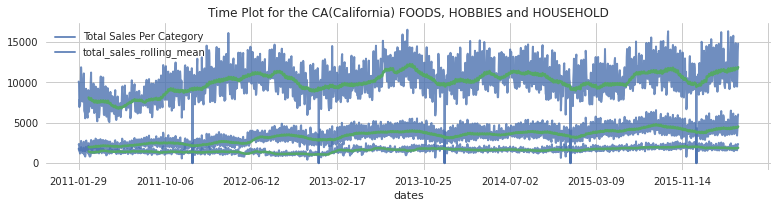

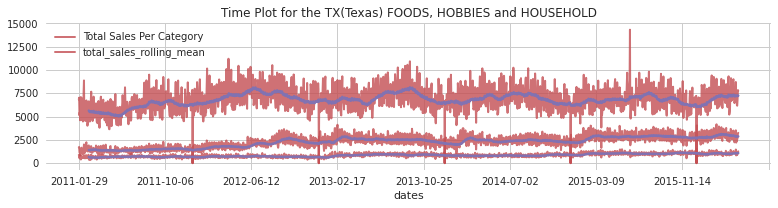

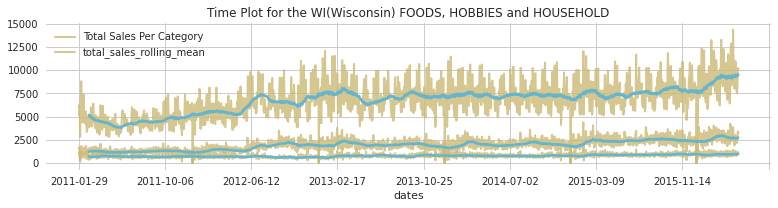

In [ ]:
time_and_rolling_plot(df_CA, 'CA(California) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_TX, 'TX(Texas) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_WI, 'WI(Wisconsin) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
#time_and_rolling_plot(df_CA.iloc[:,1].reset_index(), "CA HOBBIES")
#time_and_rolling_plot(df_CA.iloc[:,2].reset_index(), "CA State")

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)

In [ ]:
item_ids = [c for c in train_sales_cal_df.columns if 'validation' in c]

In [ ]:
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year

In [ ]:
df = train_sales_cal_df.groupby(['year', 'month'])[item_ids].sum()
df = df.reset_index()

In [ ]:
def find_items_per_specific_date(df, year, month, category, number):
    
    '''
    finds the five most sold product_ids in user specified category, year and month
    
    inputs: df(item_ids along with year and month), year, month, category (household, 
    foods or hobbies), number (how many results to be displayed)
    
    returns : table of product ids with specfied number and date and number of sales made
    '''
    
    df = df.loc[(df['year'] == year) & (df['month'] == month)][item_ids].T.reset_index()
    df.columns = ['item_id', 'sales_count']
    df = df.set_index('item_id')
    item_type = [c for c in df.index if category in c]
    df = df[df.index.isin(item_type)]
    df = df.sort_values(by = ['sales_count'], ascending=False)[:number]
    
    return df

print("Most sold Foods during requested date\n"
      ,find_items_per_specific_date(df, 2012, 7, 'FOODS', 5) )
print("Most sold Household items during requested date\n" 
      ,find_items_per_specific_date(df, 2013, 3, 'HOUSEHOLD', 5) )

Most sold Foods during requested date
                              sales_count
item_id                                 
FOODS_3_090_CA_3_validation         8054
FOODS_3_281_CA_3_validation         3851
FOODS_3_586_TX_2_validation         3458
FOODS_3_120_CA_3_validation         2940
FOODS_3_090_CA_1_validation         2780
Most sold Household items during requested date
                                  sales_count
item_id                                     
HOUSEHOLD_1_334_CA_3_validation         1346
HOUSEHOLD_1_118_CA_3_validation         1253
HOUSEHOLD_1_351_CA_3_validation         1043
HOUSEHOLD_1_277_CA_3_validation         1014
HOUSEHOLD_1_334_TX_1_validation          914


#### Phân phối Total Sales Vs Store_ID?

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['store_id'])[d_cols].sum()\
                                                .T.merge(calendar_df.set_index('d')['date'], 
                                                        left_index=True, right_index=True,
                                                        validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df.head(2)

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,
2011-01-29,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198


In [ ]:
#PLOT one by one to avoid memory overload

#plotly_time_plot_rolling(train_sales_cal_df, 'Store')
plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=4, end_col=7)
#plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=7, end_col=10)

#### Phân phối Sales theo các ngày đặc biệt như lễ và cuối tuần?

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum().\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['day'] = train_sales_cal_df.date.dt.day
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.weekday
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.day_name()
train_sales_cal_df.head(2)

,date,FOODS,HOBBIES,HOUSEHOLD,month,day,year,weekday
0,2011-01-29,23178,3764,5689,1,29,2011,Saturday
1,2011-01-30,22758,3357,5634,1,30,2011,Sunday


In [ ]:
df_food = train_sales_cal_df.groupby(['weekday', 'day'])['FOODS'].sum().reset_index(name='sales')
df_house = train_sales_cal_df.groupby(['weekday', 'day'])['HOUSEHOLD'].sum().reset_index(name='sales')
df_hob = train_sales_cal_df.groupby(['weekday', 'day'])['HOBBIES'].sum().reset_index(name='sales')

In [ ]:
def heatmap_plot_dates(df, title_text):

    '''
    returns the heatmap based plot for the df with time_series data in it
    
    inputs : df (dataframe with time based elements, such as weekdays, months etc.)
             title_text (text of the plot to be shown)
    returns : Heatmaps of Weekdays along number of days of a months
    '''
    fig = make_subplots(rows=1, cols=1, vertical_spacing = 0.15, 
                    subplot_titles=title_text,
                    shared_yaxes = True
                   )
    fig.add_trace( go.Heatmap(
                   z=[[df.loc[(df['day'] == day) & (df['weekday'] == weekday)]['sales'].sum()
                     for day in range(1, 31+1)] for weekday in df.weekday.unique()],
                   x=list(df.day.unique()),
                   y=list(df.weekday.unique()),
                   hoverongaps = False, 
                   colorbar = dict(title= title_text + '_Sales', 
                                   thickness=15)), row=1, col=1)
    fig.update_layout(title = title_text + '_Sale Distribution', height=2 * 20 + 300, width=1 * 700, showlegend=False)
    fig.show()

In [ ]:
heatmap_plot_dates(df_food, 'FOODS')
heatmap_plot_dates(df_hob, 'HOBBIES')
heatmap_plot_dates(df_house, 'HOUSEHOLD')

## Tài liệu tham khảo và các bài đọc thêm:

Khá nhiều tài nguyên hữu ích mang lại nhiều cơ hội học tập hơn được đề cập bên dưới

- https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- https://towardsdatascience.com/time-series-forecasting-a-getting-started-guide-c435f9fa2216
- https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
- https://facebook.github.io/prophet/docs/diagnostics.html
- https://www.baeldung.com/cs/mape-vs-wape-vs-wmape
- https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/144067
- Special thanks to the kernel of TSURU https://www.kaggle.com/girmdshinsei/for-japanese-beginner-with-wrmsse-in-lgbm#WRMSSE-calculation
- Specal thanks to the kernel of sibmike for making WRMSSE calculation faster https://www.kaggle.com/mubashir1/fast-clear-wrmsse-18ms/edit
- https://www.kaggle.com/binhlc/forecasting-multiple-time-series-using-prophet
- https://www.kaggle.com/tnmasui/m5-wrmsse-evaluation-dashboard